# Intro

Looking at the losses from our previous model and especially the graph with respect to training epochs, we see an unintuitive visual. The loss, instead of decreasing over time, actually increases. We see numerous causes for concern and improvements. One improvement we wish to make with this milestone is to modify our data processing. As seen in our previous notebook, there was a huge data imbalance which was further exaggerated by having 15 classes for our model to predict. In this milestone, we address both the issues by changing the output dimension of our model to (n, 1) instead of (2n, 2). More specifically, we are merging the away team play and home team play into one column and decreasing the occurrences of “no play.” Moreover, we will also be trying a DNN instead of a regular neural network to better capture the complexities for this problem.

In [ ]:
pip install scikeras

In [ ]:
pip install keras-tuner

In [ ]:
import keras
import keras_tuner
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import layers
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten
from keras.models import Sequential
from keras.optimizers import Adam
from keras_tuner.tuners import RandomSearch
from scikeras.wrappers import KerasClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

In [ ]:
raw_df = pd.read_csv('NBA_PBP_2018-19.csv')
raw_df = raw_df.drop(columns=['URL'])
raw_df.head()

,GameType,Location,Date,Time,WinningTeam,Quarter,SecLeft,AwayTeam,AwayPlay,AwayScore,...,FreeThrowNum,EnterGame,LeaveGame,TurnoverPlayer,TurnoverType,TurnoverCause,TurnoverCauser,JumpballAwayPlayer,JumpballHomePlayer,JumpballPoss
0,regular,TD Garden Boston Massachusetts,October 16 2018,8:00 PM,BOS,1,720,PHI,Jump ball: J. Embiid vs. A. Horford (B. Simmon...,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,J. Embiid - embiijo01,A. Horford - horfoal01,B. Simmons - simmobe01
1,regular,TD Garden Boston Massachusetts,October 16 2018,8:00 PM,BOS,1,700,PHI,R. Covington misses 3-pt jump shot from 27 ft,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,regular,TD Garden Boston Massachusetts,October 16 2018,8:00 PM,BOS,1,700,PHI,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,regular,TD Garden Boston Massachusetts,October 16 2018,8:00 PM,BOS,1,675,PHI,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,regular,TD Garden Boston Massachusetts,October 16 2018,8:00 PM,BOS,1,673,PHI,Defensive rebound by D. ari,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# dropped certain columns because they give away the play (i.e., what we are setting as the target class for our classification task)
dropped = ['Shooter', 'ShotType', 'ShotOutcome', 'ShotDist',
                   'Assister', 'Blocker', 'FoulType', 'Fouler', 'Fouled',
                   'Rebounder', 'ReboundType', 'ViolationPlayer',
                   'ViolationType', 'FreeThrowShooter', 'FreeThrowOutcome',
                   'FreeThrowNum', 'EnterGame', 'LeaveGame', 'TurnoverPlayer',
                   'TurnoverType', 'TurnoverCause', 'TurnoverCauser',
                   'JumpballAwayPlayer', 'JumpballHomePlayer', 'JumpballPoss', 'TimeoutTeam']


data = raw_df.copy()
data.drop(columns=dropped, inplace=True)

# function to convert AwayPlay and HomePlay descriptions into few word representations of the play
# this takes columns `AwayPlay` and `HomePlay`, and converts them into `RefactoredAwayPlay` and `RefactoredHomePlay`
def refactor_play(play):
    if pd.isnull(play):
        return "no-play"
    elif "makes" in play:
        return "make"
    elif "misses" in play:
        return "miss"
    elif "rebound" in play:
        return "rebound"
    elif "turnover" in play:
        return "turnover"
    elif "Jump ball" in play:
        return "jump-ball"
    elif "foul" in play:
        return "foul"
    else:
        return "other"

data['RefactoredAwayPlay'] = data['AwayPlay'].apply(lambda x: refactor_play(x))
data['RefactoredHomePlay'] = data['HomePlay'].apply(lambda x: refactor_play(x))

def combined_play(row):
    if row['RefactoredAwayPlay'] != 'no-play':
        return row['RefactoredAwayPlay']
    elif row['RefactoredHomePlay'] != 'no-play':
        return row['RefactoredHomePlay']
    else:
        return 'no-play'

data['play'] = data.apply(combined_play, axis=1)

data.drop(columns=['RefactoredAwayPlay', 'RefactoredHomePlay'], inplace=True)
data.drop(columns=['AwayPlay', 'HomePlay'], inplace=True)

data.head()

,GameType,Location,Date,Time,WinningTeam,Quarter,SecLeft,AwayTeam,AwayScore,HomeTeam,HomeScore,play
0,regular,TD Garden Boston Massachusetts,October 16 2018,8:00 PM,BOS,1,720,PHI,0,BOS,0,jump-ball
1,regular,TD Garden Boston Massachusetts,October 16 2018,8:00 PM,BOS,1,700,PHI,0,BOS,0,miss
2,regular,TD Garden Boston Massachusetts,October 16 2018,8:00 PM,BOS,1,700,PHI,0,BOS,0,rebound
3,regular,TD Garden Boston Massachusetts,October 16 2018,8:00 PM,BOS,1,675,PHI,0,BOS,0,miss
4,regular,TD Garden Boston Massachusetts,October 16 2018,8:00 PM,BOS,1,673,PHI,0,BOS,0,rebound


In [ ]:
# converted date and time into meaningful representations by splitting them into year, month, day, hour and minute
data['Date'] = pd.to_datetime(data['Date'])
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day

data['Time'] = pd.to_datetime(data['Time']).dt.strftime('%H:%M:%S')
data['Hour'] = pd.to_datetime(data['Time']).dt.hour
data['Minute'] = pd.to_datetime(data['Time']).dt.minute

data.drop(columns=['Date', 'Time'], inplace=True)

data.head()

,GameType,Location,WinningTeam,Quarter,SecLeft,AwayTeam,AwayScore,HomeTeam,HomeScore,play,Year,Month,Day,Hour,Minute
0,regular,TD Garden Boston Massachusetts,BOS,1,720,PHI,0,BOS,0,jump-ball,2018,10,16,20,0
1,regular,TD Garden Boston Massachusetts,BOS,1,700,PHI,0,BOS,0,miss,2018,10,16,20,0
2,regular,TD Garden Boston Massachusetts,BOS,1,700,PHI,0,BOS,0,rebound,2018,10,16,20,0
3,regular,TD Garden Boston Massachusetts,BOS,1,675,PHI,0,BOS,0,miss,2018,10,16,20,0
4,regular,TD Garden Boston Massachusetts,BOS,1,673,PHI,0,BOS,0,rebound,2018,10,16,20,0


In [ ]:
# encoded the column team and location columns
# did not one-hot encode teams and locations because it would produce too many columns
# instead a dictionary maps every unique team and location to a unique index
# also print `finalDf` and notice the differences from the above data's head()
finalDf = data.copy()
teams = pd.concat([finalDf['AwayTeam'], finalDf['HomeTeam']])
uniqueTeams = teams.unique()
teamDict = {value: index + 1 for index, value in enumerate(uniqueTeams)}

def encodeTeams(column):
    column.replace(teamDict, inplace=True)

encodeTeams(finalDf['AwayTeam'])
encodeTeams(finalDf['HomeTeam'])
encodeTeams(finalDf['WinningTeam'])

locs = finalDf['Location'].unique()
locsDict = {value: index + 1 for index, value in enumerate(locs)}

def encodeLocs(column):
    column.replace(locsDict, inplace=True)

encodeLocs(finalDf['Location'])
finalDf.head()

,GameType,Location,WinningTeam,Quarter,SecLeft,AwayTeam,AwayScore,HomeTeam,HomeScore,play,Year,Month,Day,Hour,Minute
0,regular,1,19,1,720,1,0,19,0,jump-ball,2018,10,16,20,0
1,regular,1,19,1,700,1,0,19,0,miss,2018,10,16,20,0
2,regular,1,19,1,700,1,0,19,0,rebound,2018,10,16,20,0
3,regular,1,19,1,675,1,0,19,0,miss,2018,10,16,20,0
4,regular,1,19,1,673,1,0,19,0,rebound,2018,10,16,20,0


In [ ]:
print(finalDf['play'].unique())

['jump-ball' 'miss' 'rebound' 'other' 'make' 'foul' 'turnover' 'no-play']


In [ ]:
teamDict

{'PHI': 1,
 'OKC': 2,
 'MIL': 3,
 'BRK': 4,
 'MEM': 5,
 'MIA': 6,
 'ATL': 7,
 'CLE': 8,
 'NOP': 9,
 'MIN': 10,
 'UTA': 11,
 'DEN': 12,
 'DAL': 13,
 'CHI': 14,
 'LAL': 15,
 'CHO': 16,
 'NYK': 17,
 'SAC': 18,
 'BOS': 19,
 'IND': 20,
 'GSW': 21,
 'TOR': 22,
 'ORL': 23,
 'DET': 24,
 'PHO': 25,
 'SAS': 26,
 'HOU': 27,
 'WAS': 28,
 'LAC': 29,
 'POR': 30}

In [ ]:
locsDict

{'TD Garden Boston Massachusetts': 1,
 'Oracle Arena Oakland California': 2,
 'Spectrum Center Charlotte North Carolina': 3,
 'Little Caesars Arena Detroit Michigan': 4,
 'Bankers Life Fieldhouse Indianapolis Indiana': 5,
 'Amway Center Orlando Florida': 6,
 'Madison Square Garden (IV) New York New York': 7,
 'Scotiabank Arena Toronto Canada': 8,
 'Toyota Center Houston Texas': 9,
 'AT&T Center San Antonio Texas': 10,
 'Golden 1 Center Sacramento California': 11,
 'STAPLES Center Los Angeles California': 12,
 'Talking Stick Resort Arena Phoenix Arizona': 13,
 'Wells Fargo Center Philadelphia Pennsylvania': 14,
 'Capital One Arena Washington District of Columbia': 15,
 'Moda Center Portland Oregon': 16,
 'Barclays Center Brooklyn New York': 17,
 'FedEx Forum Memphis Tennessee': 18,
 'Target Center Minneapolis Minnesota': 19,
 'Smoothie King Center New Orleans Louisiana': 20,
 'Fiserv Forum Milwaukee Wisconsin': 21,
 'Vivint Smart Home Arena Salt Lake City Utah': 22,
 'United Center Chic

In [ ]:
# normalize all numerical columns and put into normDf
scaler = MinMaxScaler()
numCols = ['Location', 'Quarter', 'SecLeft', 'AwayScore', 'HomeScore', 'Year', 'Month', 'Day', 'Hour', 'Minute']
normDf = pd.DataFrame(scaler.fit_transform(finalDf[numCols]), columns=numCols)


# one-hot encoding categorical columns
categorical_cols = ['GameType', 'play']
encoder = OneHotEncoder()
encodedCol = encoder.fit_transform(finalDf[categorical_cols])
encodedDf = pd.DataFrame(encodedCol.toarray(), columns=encoder.get_feature_names_out(categorical_cols))


finalDf = pd.concat([normDf, encodedDf], axis=1)
finalDf.head()

,Location,Quarter,SecLeft,AwayScore,HomeScore,Year,Month,Day,Hour,Minute,GameType_playoff,GameType_regular,play_foul,play_jump-ball,play_make,play_miss,play_no-play,play_other,play_rebound,play_turnover
0,0.0,0.0,1.000000,0.0,0.0,0.0,0.818182,0.5,0.8,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.972222,0.0,0.0,0.0,0.818182,0.5,0.8,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.972222,0.0,0.0,0.0,0.818182,0.5,0.8,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.937500,0.0,0.0,0.0,0.818182,0.5,0.8,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.934722,0.0,0.0,0.0,0.818182,0.5,0.8,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
# possible categories: no-play, make, miss, rebound, turnover, jump ball, foul, other

# why is there 8 for away play and 7 for home play ???

targets = ['play_foul', 'play_make',
       'play_miss', 'play_other', 'play_rebound',
       'play_turnover','play_jump-ball', 'play_no-play']
X = finalDf.drop(targets, axis=1)
y = finalDf[targets]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
y_train.shape

(491612, 8)

In [ ]:
model_Two_classifier = Sequential([
    Dense(16, input_dim=X_train.shape[1], activation='relu'),
    Dense(32, activation='relu'),
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(10, activation='relu'),
    Dense(8, activation='softmax')
])

In [ ]:
opt = Adam(learning_rate=0.001)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=10,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=0
)

model_Two_classifier.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
history_Two = model_Two_classifier.fit(X_train.astype('float'), y_train, batch_size=64, validation_split=0.2, epochs=15, callbacks=[early_stopping], verbose=0)

In [ ]:
history_Two.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

train accuracy:0.26559096574783325
val accuracy: 0.26371246576309204


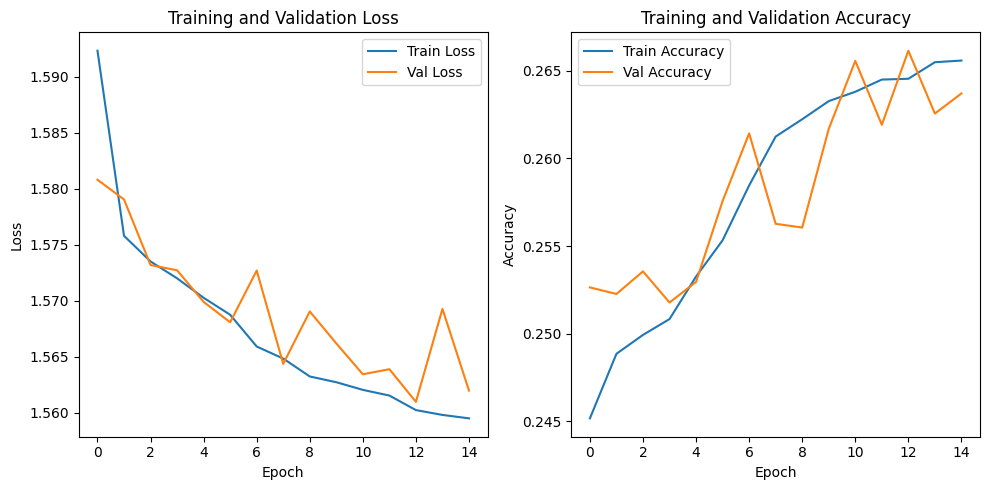

In [ ]:
import matplotlib.pyplot as plt

print('train accuracy:'  + str(history_Two.history['accuracy'][-1]))
print('val accuracy: ' + str(history_Two.history['val_accuracy'][-1]))


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history_Two.history['loss'], label='Train Loss')
plt.plot(history_Two.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_Two.history['accuracy'], label='Train Accuracy')
plt.plot(history_Two.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()


plt.tight_layout()
plt.show()

In [ ]:
preds_Two = model_Two_classifier.predict(X_test)
max_indices = np.argmax(preds_Two, axis=1)
preds = max_indices.reshape(-1, 1)

y_indices = np.argmax(np.array(y_test), axis=1)
y_test_reshaped = y_indices.reshape(-1, 1)

print("Classification Report for model_Two_classifier:")
print(classification_report(y_test_reshaped, preds))

3841/3841 [==============================] - 6s 2ms/step
Classification Report for model_Two_classifier:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     12290
           1       0.26      0.65      0.37     30813
           2       0.27      0.17      0.21     28082
           3       0.28      0.32      0.30     23293
           4       0.20      0.00      0.00     27931
           5       0.00      0.00      0.00        24
           6       0.99      0.49      0.66       471

    accuracy                           0.27    122904
   macro avg       0.28      0.23      0.22    122904
weighted avg       0.23      0.27      0.20    122904



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score
from scikeras.wrappers import KerasClassifier
from sklearn.metrics import classification_report

model = KerasClassifier(model_Two_classifier)

# Define parameter grid
param_grid = {
    'batch_size': [32, 64],
    'epochs': [3, 3],
}

# Define scoring metric
scoring = {'accuracy': make_scorer(accuracy_score)}

In [ ]:
# Perform Grid Search
grid_search = GridSearchCV(model, param_grid=param_grid, scoring='accuracy', cv=2)
grid_search.fit(X_train.values, y_train.values)
# Print the best parameters
print("Best parameters found: ", grid_search.best_params_)


Epoch 1/3
7682/7682 [==============================] - 27s 3ms/step - loss: 1.5620 - accuracy: 0.2642
Epoch 2/3
7682/7682 [==============================] - 26s 3ms/step - loss: 1.5620 - accuracy: 0.2633
Epoch 3/3
7682/7682 [==============================] - 14s 2ms/step


Epoch 1/3
7682/7682 [==============================] - 27s 3ms/step - loss: 1.5617 - accuracy: 0.2645
Epoch 2/3
7682/7682 [==============================] - 26s 3ms/step - loss: 1.5614 - accuracy: 0.2645
Epoch 3/3
7682/7682 [==============================] - 14s 2ms/step
Epoch 1/3
7682/7682 [==============================] - 27s 3ms/step - loss: 1.5620 - accuracy: 0.2638
Epoch 2/3
7682/7682 [==============================] - 28s 4ms/step - loss: 1.5618 - accuracy: 0.2639
Epoch 3/3
7682/7682 [==============================] - 14s 2ms/step


Epoch 1/3
7682/7682 [==============================] - 27s 3ms/step - loss: 1.5615 - accuracy: 0.2642
Epoch 2/3
7682/7682 [==============================] - 27s 3ms/step - loss: 1.5609 - accuracy: 0.2656
Epoch 3/3
7682/7682 [==============================] - 15s 2ms/step
Epoch 1/3
3841/3841 [==============================] - 19s 5ms/step - loss: 1.5600 - accuracy: 0.2652
Epoch 2/3
3841/3841 [==============================] - 17s 4ms/step - loss: 1.5597 - accuracy: 0.2657
Epoch 3/3
3841/3841 [==============================] - 9s 2ms/step
Epoch 1/3
3841/3841 [==============================] - 18s 4ms/step - loss: 1.5590 - accuracy: 0.2666
Epoch 2/3
3841/3841 [==============================] - 18s 5ms/step - loss: 1.5586 - accuracy: 0.2659
Epoch 3/3
3841/3841 [==============================] - 9s 2ms/step


Epoch 1/3
3841/3841 [==============================] - 19s 5ms/step - loss: 1.5597 - accuracy: 0.2659
Epoch 2/3
3841/3841 [==============================] - 19s 5ms/step - loss: 1.5598 - accuracy: 0.2652
Epoch 3/3
3841/3841 [==============================] - 9s 2ms/step
Epoch 1/3
3841/3841 [==============================] - 18s 4ms/step - loss: 1.5591 - accuracy: 0.2664
Epoch 2/3
3841/3841 [==============================] - 19s 5ms/step - loss: 1.5591 - accuracy: 0.2663
Epoch 3/3
3841/3841 [==============================] - 9s 2ms/step


Epoch 1/3
15363/15363 [==============================] - 56s 4ms/step - loss: 1.5617 - accuracy: 0.2642
Epoch 2/3
15363/15363 [==============================] - 55s 4ms/step - loss: 1.5614 - accuracy: 0.2647
Epoch 3/3
15363/15363 [==============================] - 57s 4ms/step - loss: 1.5604 - accuracy: 0.2649
Best parameters found:  {'batch_size': 32, 'epochs': 3}


Epoch 1/3
15363/15363 [==============================] - 55s 4ms/step - loss: 1.5580 - accuracy: 0.2687
Epoch 2/3
15363/15363 [==============================] - 54s 4ms/step - loss: 1.5560 - accuracy: 0.2701
Epoch 3/3
3841/3841 [==============================] - 7s 2ms/step - loss: 1.5520 - accuracy: 0.2745
Test Loss: 1.552019715309143
Test Accuracy: 0.2744743824005127


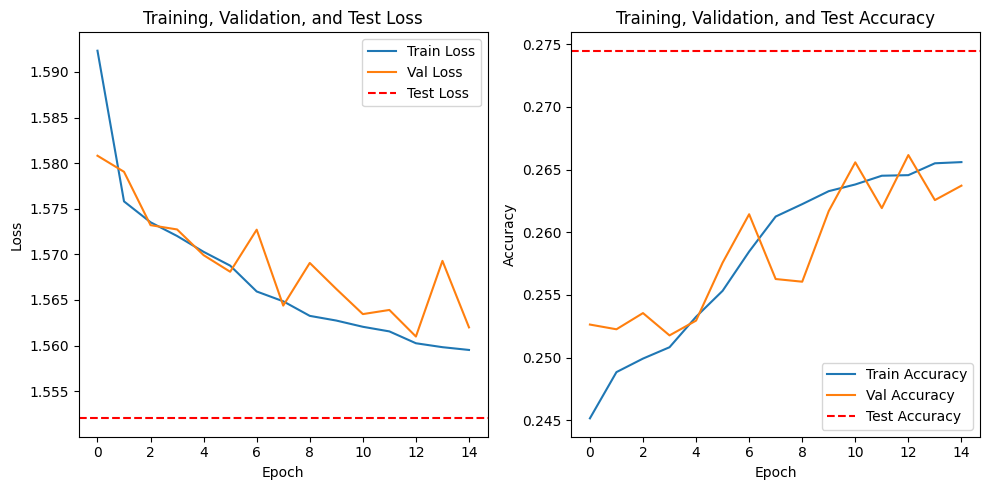

In [ ]:
# Train the model on the full training set with the best hyperparameters
best_model = grid_search.best_estimator_
best_model.fit(X_train.values, y_train.values)

# Evaluate the model on the testing set
test_loss, test_accuracy = best_model.model.evaluate(X_test.values, y_test.values)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Graph the results for training vs validation vs testing
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history_Two.history['loss'], label='Train Loss')
plt.plot(history_Two.history['val_loss'], label='Val Loss')
plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training, Validation, and Test Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_Two.history['accuracy'], label='Train Accuracy')
plt.plot(history_Two.history['val_accuracy'], label='Val Accuracy')
plt.axhline(y=test_accuracy, color='r', linestyle='--', label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training, Validation, and Test Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Conclusion

Our second modrl is a neural network classifier designed to predict various play types in basketball games based on our dataset containing features such as game type, location, quarter, time remaining, scores, and play descriptions. The model achieved decent accuracy after training for 15 epochs, with approximately 26.56% on the training set and 26.37% on the validation set. The classification report reveals some varience in the model's performance across different play types, with relatively higher precision and recall for predicting "play_make" and "play_turnover," but lower scores for classes like "play_foul" and "play_rebound." To improve the model we can include other features to incorporate additional relevant features such as time remaining in the quarter and player statistics. Also, we can experiment with different neural network architectures and hyperparameters to help find a more suitable model configuration. Our model 2 shows improvement over our model 1 by achieving stable losses and predicting multiple classes, with modest accuracy. While both models have data imbalance, model 2 attempts to address this issue through further one-hot encoding, showing our attempt to handle our data sets challenges that we saw in model 1.




